In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from bertviz import model_view, head_view

# Download NLTK

In [528]:
# Download required NLTK data
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Check for CUDA device

In [529]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("\nGPU Information:")
    print("- GPU Available: Yes")
    print(f"- GPU Device Name: {torch.cuda.get_device_name(0)}")
    print(f"- Number of GPUs: {torch.cuda.device_count()}")
    print(f"- CUDA Version: {torch.version.cuda}")

    # Print memory information
    memory_allocated = torch.cuda.memory_allocated(0) / 1024**2
    memory_cached = torch.cuda.memory_reserved(0) / 1024**2
    print(f"- GPU Memory Allocated: {memory_allocated:.2f} MB")
    print(f"- GPU Memory Cached: {memory_cached:.2f} MB")
else:
    device = torch.device("cpu")
    print("\nGPU not available, using CPU instead")



GPU Information:
- GPU Available: Yes
- GPU Device Name: NVIDIA GeForce GTX 1060
- Number of GPUs: 1
- CUDA Version: 11.8
- GPU Memory Allocated: 741.54 MB
- GPU Memory Cached: 2746.00 MB


In [530]:
df = pd.read_json("../data/full_format_recipes.json")

# Step 1: Initialize and process data

In [531]:
# Handle directions (list of strings) by joining them
df["directions_pre"] = df["directions"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)
df["categories_pre"] = df["categories"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)
df["ingredients_pre"] = df["ingredients"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)
df["rating_pre"] = pd.to_numeric(df["rating"], errors="coerce")
df["rating_pre"] = df["rating_pre"].fillna(df["rating_pre"].mean())
df["desc_pre"] = df["desc"].fillna("")


**Relationship between categories and rating**

C:\Users\Iker_Al\AppData\Local\Temp\ipykernel_8336\839261994.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


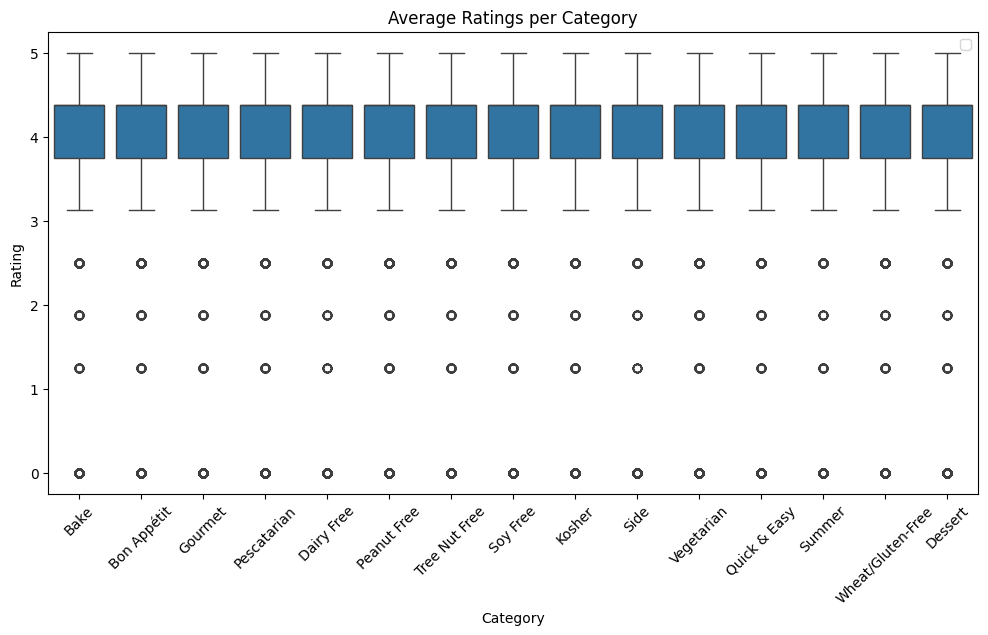

In [ ]:
# Get the Top 10 most common categories
category_counts = df["categories"].explode().value_counts()[:15]
top_categories = category_counts.index

df["categories"] = df["categories"].apply(lambda x: x if isinstance(x, list) else [])
filtered_data = df[
    df["categories"].apply(lambda x: any(cat in top_categories for cat in x))
]

# Create a category-rating relationship
category_rating = filtered_data.explode("categories")
category_rating = category_rating[category_rating["categories"].isin(top_categories)]

plt.figure(figsize=(12, 6))
sns.boxplot(x="categories", y="rating", data=category_rating)
plt.xticks(rotation=45)
plt.title("Average Ratings per Category")
plt.xlabel("Category")
plt.ylabel("Rating")
plt.legend()
plt.show()


Numerical Features Correlation

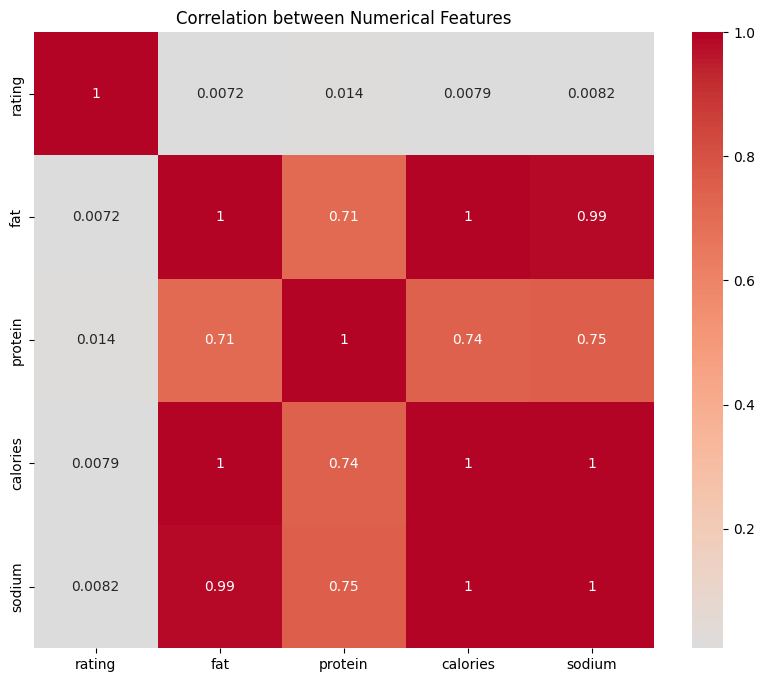

In [ ]:
numerical_cols = ["rating", "fat", "protein", "calories", "sodium"]
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Numerical Features")
plt.show()


Distribution of Ratings (Target Variable):

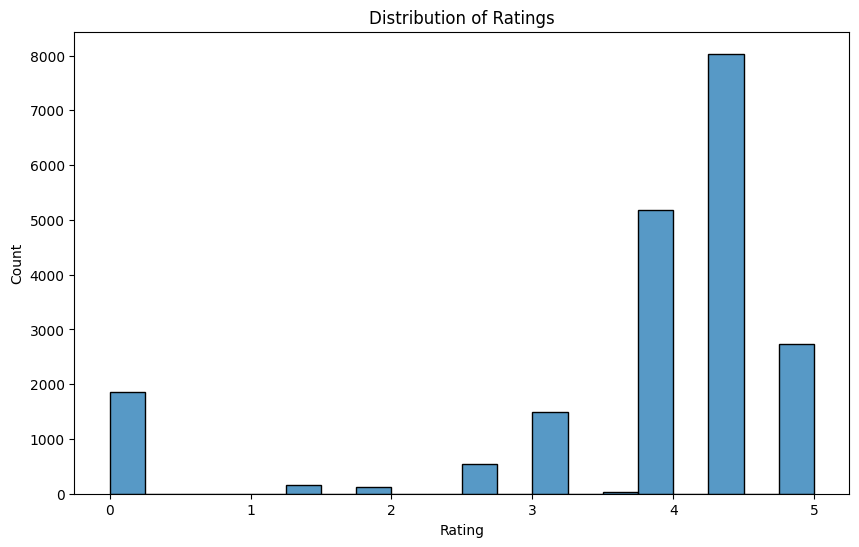

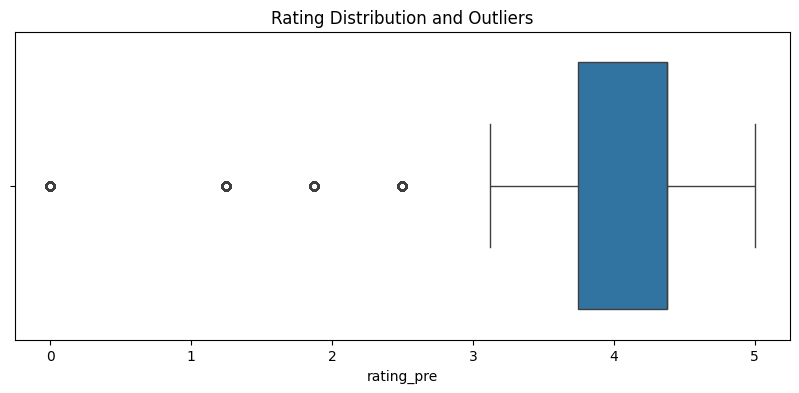

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="rating_pre", bins=20)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Add boxplot to see outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["rating_pre"])
plt.title("Rating Distribution and Outliers")
plt.show()


Nutritional Content vs Rating

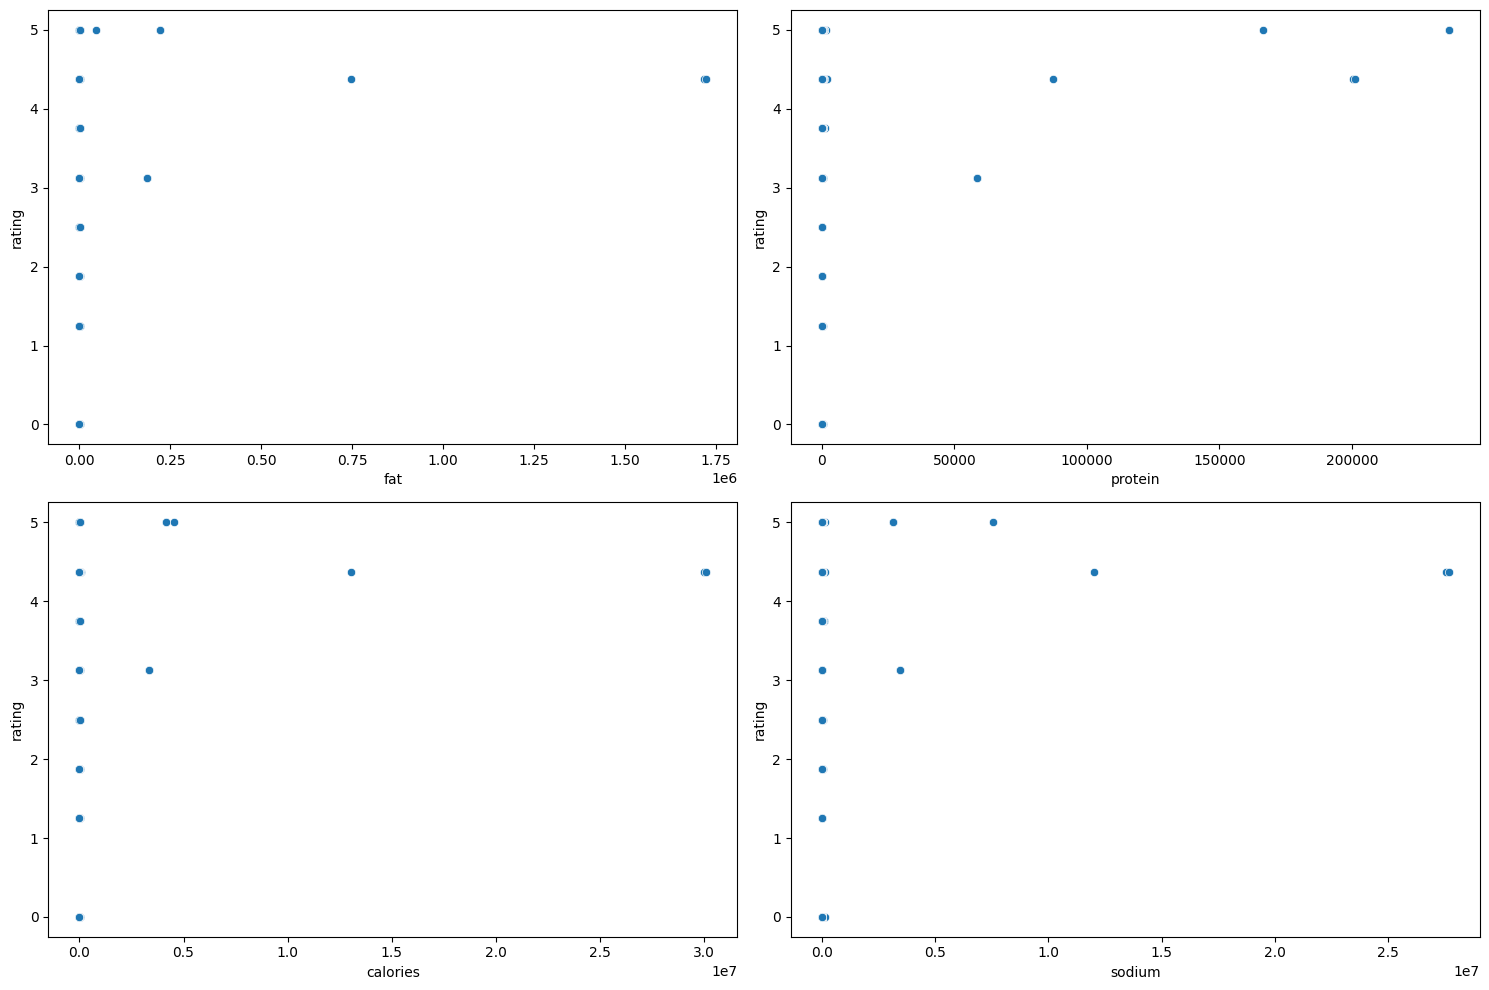

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(data=df, x="fat", y="rating", ax=axes[0, 0])
sns.scatterplot(data=df, x="protein", y="rating", ax=axes[0, 1])
sns.scatterplot(data=df, x="calories", y="rating", ax=axes[1, 0])
sns.scatterplot(data=df, x="sodium", y="rating", ax=axes[1, 1])
plt.tight_layout()
plt.show()


Text Length Analysis

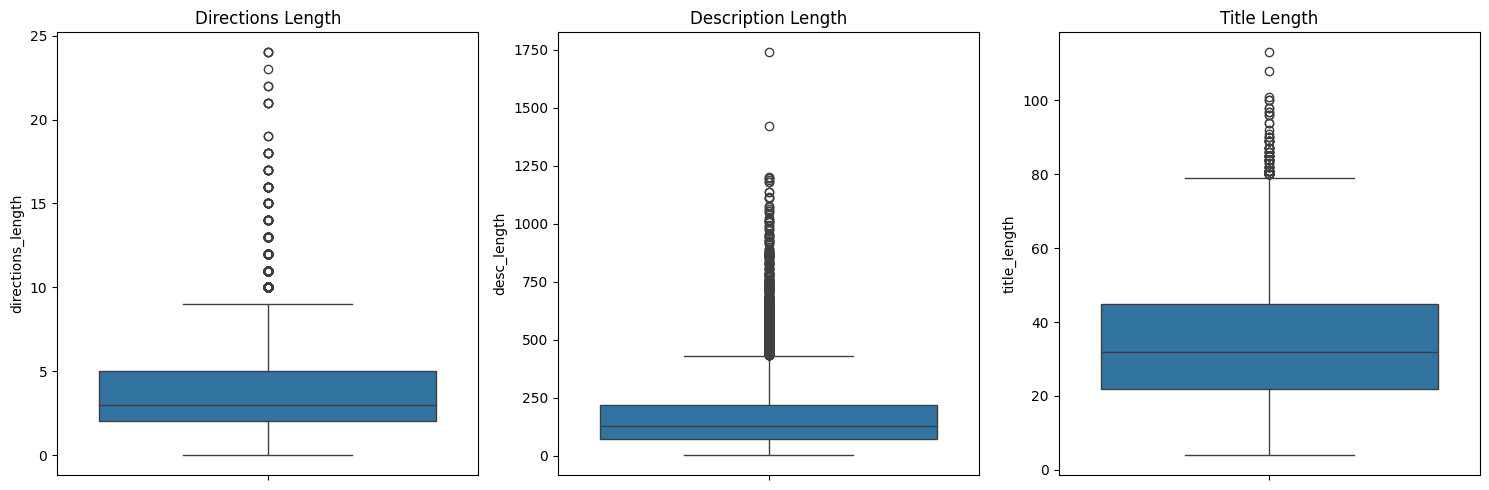

In [ ]:
df["directions_length"] = df["directions"].str.len()
df["desc_length"] = df["desc"].str.len()
df["title_length"] = df["title"].str.len()

plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.boxplot(y=df["directions_length"])
plt.title("Directions Length")
plt.subplot(132)
sns.boxplot(y=df["desc_length"])
plt.title("Description Length")
plt.subplot(133)
sns.boxplot(y=df["title_length"])
plt.title("Title Length")
plt.tight_layout()
plt.show()


Time Analysis

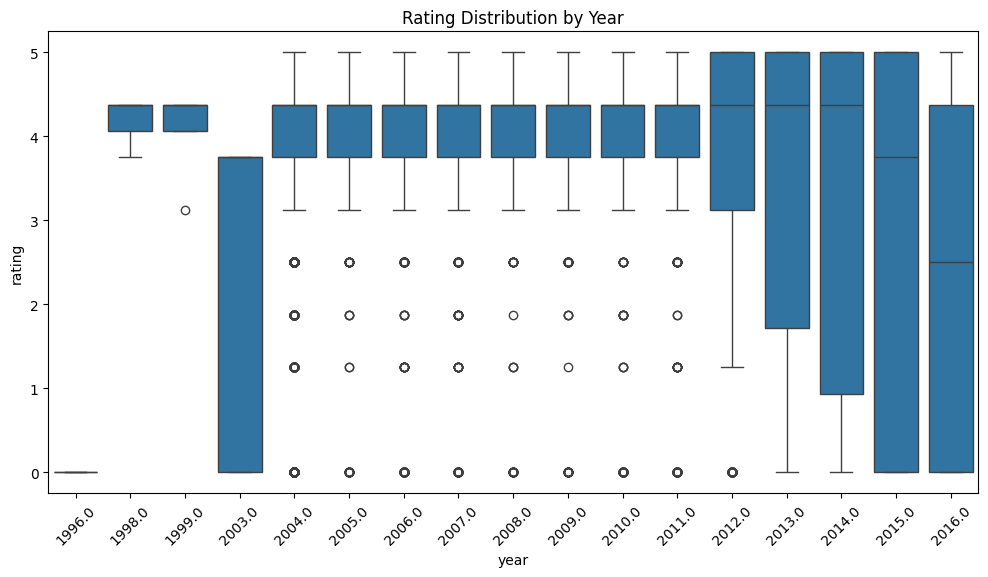

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

plt.figure(figsize=(12, 6))
sns.boxplot(x="year", y="rating", data=df)
plt.title("Rating Distribution by Year")
plt.xticks(rotation=45)
plt.show()


Categories Analysis

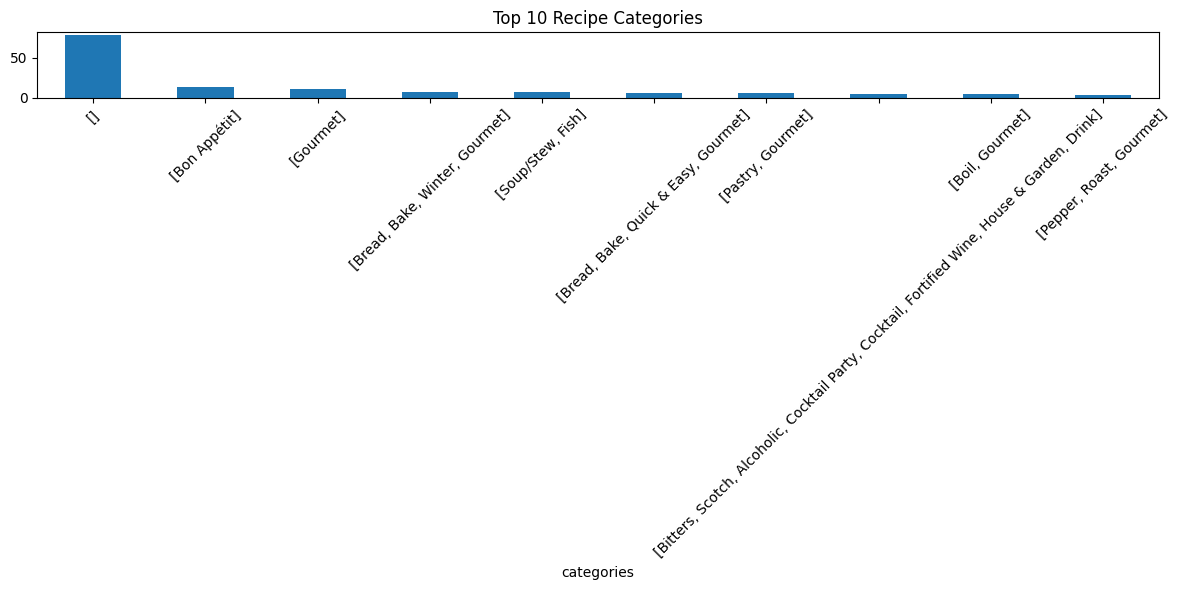

In [ ]:
plt.figure(figsize=(12, 6))
df["categories"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Recipe Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Step 2: Pre-Processing

In [451]:
def preprocess(text):
    """Simplified text preprocessing function."""
    stop_words = set(stopwords.words("english"))
    if not isinstance(text, str):
        return ""

    try:
        # Initialize lemmatizer
        lemmatizer = WordNetLemmatizer()

        # Convert to lowercase
        text = text.lower()

        # Remove special characters and digits
        text = re.sub(r"[^a-zA-Z\s]", "", text)

        # Remove extra whitespace
        text = " ".join(text.split())

        # Remove extra whitespace
        text = lemmatizer.lemmatize(text)

        # Basic word tokenization (split by space)
        tokens = word_tokenize(text)

        # Remove stopwords
        tokens = [token for token in tokens if token not in stop_words]

        return " ".join(tokens)
    except Exception as e:
        print(f"Error in text preprocessing: {str(e)}")
        return ""


In [452]:
df["directions_post"] = df["directions_pre"].apply(preprocess)
df["categories_post"] = df["categories_pre"].apply(preprocess)
df["ingredients_post"] = df["ingredients_pre"].apply(preprocess)


In [453]:
df["directions_post"].info

<bound method Series.info of 0        place stock lentils celery carrot thyme salt m...
1        combine first ingredients heavy medium saucepa...
2        large heavy saucepan cook diced fennel onion b...
3        heat oil heavy large skillet mediumhigh heat a...
4        preheat oven f lightly grease xxinch glass bak...
                               ...                        
20125    beat whites bowl electric mixer hold stiff pea...
20126    bring broth simmer saucepanremove heat cover k...
20127    using sharp knife cut shallow x bottom tomato ...
20128    heat tablespoons oil heavy medium skillet medi...
20129    position rack bottom third oven preheat f plac...
Name: directions_post, Length: 20130, dtype: object>

# Step 5: BERT

In [454]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model = model.to(device)

bert_vectors = []
batch_size = 32

# Process in batches to handle memory constraints
for i in range(0, len(df), batch_size):
    batch_texts = df["directions_post"].iloc[i : i + batch_size].tolist()
    inputs = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )

    # Move inputs to the same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        # Use [CLS] token embeddings as document representation
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        bert_vectors.extend(batch_embeddings)


In [455]:
vectors = np.array(bert_vectors)
print(f"Created BERT vectors with shape: {vectors.shape}")


Created BERT vectors with shape: (20130, 768)


# Step 6: Neural network - BERT

In [456]:
features_scaled = StandardScaler().fit_transform(vectors)
targets = df["rating_pre"]
print("Scaled features shape:", features_scaled.shape)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, targets, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
X_test_t = torch.FloatTensor(X_test)
y_train_t = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_t = torch.FloatTensor(y_test.values).reshape(-1, 1)
print("X_train tensor shape:", X_train_t.shape)
print("y_train tensor shape:", y_train_t.shape)

# Now create the model with the correct input size
input_size = vectors.shape[1]  # This will get the correct dimension
print("Input size:", input_size)


Scaled features shape: (20130, 768)
X_train shape: (16104, 768)
y_train shape: (16104,)
X_train tensor shape: torch.Size([16104, 768])
y_train tensor shape: torch.Size([16104, 1])
Input size: 768


In [457]:
model_ML = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)


In [458]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_ML.parameters(), lr=0.001)

# Training loop
epochs = 20
batch_size = 32

predictions = []
actuals = []

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    for i in range(0, len(X_train_t), batch_size):
        # Get batch
        batch_X = X_train_t[i : i + batch_size]
        batch_y = y_train_t[i : i + batch_size]

        # Forward pass
        outputs = model_ML(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # Print progress every epoch
    avg_loss = total_loss / num_batches
    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}, Loss Item: {loss.item():.4f}"
        )


Epoch [5/20], Average Loss: 1.2710, Loss Item: 0.2005
Epoch [10/20], Average Loss: 0.7927, Loss Item: 0.1728
Epoch [15/20], Average Loss: 0.5387, Loss Item: 0.3188
Epoch [20/20], Average Loss: 0.4117, Loss Item: 0.2062


In [459]:
# Evaluation
model_ML.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Get predictions for training set
    train_predictions = model_ML(X_train_t)
    train_mse = mean_squared_error(y_train_t.numpy(), train_predictions.numpy())
    train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())

    # Get predictions for test set
    test_predictions = model_ML(X_test_t)
    test_mse = mean_squared_error(y_test_t.numpy(), test_predictions.numpy())
    test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())

print("\nTraining Set Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")



Training Set Metrics:
MSE: 0.6397
R²: 0.6447

Test Set Metrics:
MSE: 2.0422
R²: -0.1317


This is overfitted

In [460]:
model_ML = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.ReLU(),
    nn.Dropout(0.3),  # Add dropout
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),  # Add dropout
    nn.Linear(64, 1),
)


In [461]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model_ML.parameters(), lr=0.001, weight_decay=0.01
)  # Add weight_decay

# Training loop
epochs = 100
batch_size = 32

predictions = []
actuals = []

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    for i in range(0, len(X_train_t), batch_size):
        # Get batch
        batch_X = X_train_t[i : i + batch_size]
        batch_y = y_train_t[i : i + batch_size]

        # Forward pass
        outputs = model_ML(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # Print progress every epoch
    avg_loss = total_loss / num_batches
    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}, Loss Item: {loss.item():.4f}"
        )


Epoch [5/100], Average Loss: 1.7679, Loss Item: 1.8108
Epoch [10/100], Average Loss: 1.6922, Loss Item: 1.1983
Epoch [15/100], Average Loss: 1.6366, Loss Item: 0.9333
Epoch [20/100], Average Loss: 1.5955, Loss Item: 0.7261
Epoch [25/100], Average Loss: 1.5619, Loss Item: 0.8225
Epoch [30/100], Average Loss: 1.5366, Loss Item: 1.1619
Epoch [35/100], Average Loss: 1.5178, Loss Item: 0.3369
Epoch [40/100], Average Loss: 1.5004, Loss Item: 0.4428
Epoch [45/100], Average Loss: 1.5039, Loss Item: 1.4531
Epoch [50/100], Average Loss: 1.4852, Loss Item: 1.2427
Epoch [55/100], Average Loss: 1.4653, Loss Item: 1.3824
Epoch [60/100], Average Loss: 1.4614, Loss Item: 0.9604
Epoch [65/100], Average Loss: 1.4576, Loss Item: 0.3961
Epoch [70/100], Average Loss: 1.4539, Loss Item: 0.5445
Epoch [75/100], Average Loss: 1.4516, Loss Item: 1.4316
Epoch [80/100], Average Loss: 1.4511, Loss Item: 0.2919
Epoch [85/100], Average Loss: 1.4543, Loss Item: 1.1075
Epoch [90/100], Average Loss: 1.4486, Loss Item: 

In [462]:
# Evaluation
model_ML.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Get predictions for training set
    train_predictions = model_ML(X_train_t)
    train_mse = mean_squared_error(y_train_t.numpy(), train_predictions.numpy())
    train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())

    # Get predictions for test set
    test_predictions = model_ML(X_test_t)
    test_mse = mean_squared_error(y_test_t.numpy(), test_predictions.numpy())
    test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())

print("\nTraining Set Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")



Training Set Metrics:
MSE: 1.3085
R²: 0.2732

Test Set Metrics:
MSE: 1.5899
R²: 0.1190


Graphs

In [463]:
model_ML = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.ReLU(),
    nn.Dropout(0.3),  # Add dropout
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),  # Add dropout
    nn.Linear(64, 1),
)


In [464]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model_ML.parameters(), lr=0.001, weight_decay=0.01
)  # Add weight_decay

# Lists to store metrics
train_losses = []
epochs_list = []
train_r2_scores = []
test_r2_scores = []  # Added test R² tracking

# Training loop
epochs = 100
batch_size = 32

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    for i in range(0, len(X_train_t), batch_size):
        batch_X = X_train_t[i : i + batch_size]
        batch_y = y_train_t[i : i + batch_size]

        outputs = model_ML(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # Calculate average loss for this epoch
    avg_loss = total_loss / num_batches

    # Calculate R² scores for both train and test
    model_ML.eval()
    with torch.no_grad():
        train_predictions = model_ML(X_train_t)
        test_predictions = model_ML(X_test_t)
        train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())
        test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())
    model_ML.train()

    # Store metrics
    train_losses.append(avg_loss)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)  # Store test R²
    epochs_list.append(epoch + 1)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}"
        )


Epoch [5/100], Loss: 1.7625, Train R²: 0.1708, Test R²: 0.0537
Epoch [10/100], Loss: 1.6920, Train R²: 0.1875, Test R²: 0.0749
Epoch [15/100], Loss: 1.6347, Train R²: 0.1785, Test R²: 0.0707
Epoch [20/100], Loss: 1.5921, Train R²: 0.1779, Test R²: 0.0746
Epoch [25/100], Loss: 1.5457, Train R²: 0.2138, Test R²: 0.0981
Epoch [30/100], Loss: 1.5320, Train R²: 0.2256, Test R²: 0.1038
Epoch [35/100], Loss: 1.5252, Train R²: 0.2236, Test R²: 0.1131
Epoch [40/100], Loss: 1.4979, Train R²: 0.2308, Test R²: 0.1123
Epoch [45/100], Loss: 1.5037, Train R²: 0.2170, Test R²: 0.0928
Epoch [50/100], Loss: 1.4713, Train R²: 0.2518, Test R²: 0.1022
Epoch [55/100], Loss: 1.4817, Train R²: 0.2407, Test R²: 0.0987
Epoch [60/100], Loss: 1.4685, Train R²: 0.2451, Test R²: 0.0988
Epoch [65/100], Loss: 1.4635, Train R²: 0.2555, Test R²: 0.1041
Epoch [70/100], Loss: 1.4590, Train R²: 0.2581, Test R²: 0.1102
Epoch [75/100], Loss: 1.4510, Train R²: 0.2508, Test R²: 0.1048
Epoch [80/100], Loss: 1.4369, Train R²: 0

In [465]:
# Final evaluation
model_ML.eval()
with torch.no_grad():
    # Get predictions for training set
    train_predictions = model_ML(X_train_t)
    train_mse = mean_squared_error(y_train_t.numpy(), train_predictions.numpy())
    train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())

    # Get predictions for test set
    test_predictions = model_ML(X_test_t)
    test_mse = mean_squared_error(y_test_t.numpy(), test_predictions.numpy())
    test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())

print("\nTraining Set Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")



Training Set Metrics:
MSE: 1.2886
R²: 0.2843

Test Set Metrics:
MSE: 1.6267
R²: 0.0985


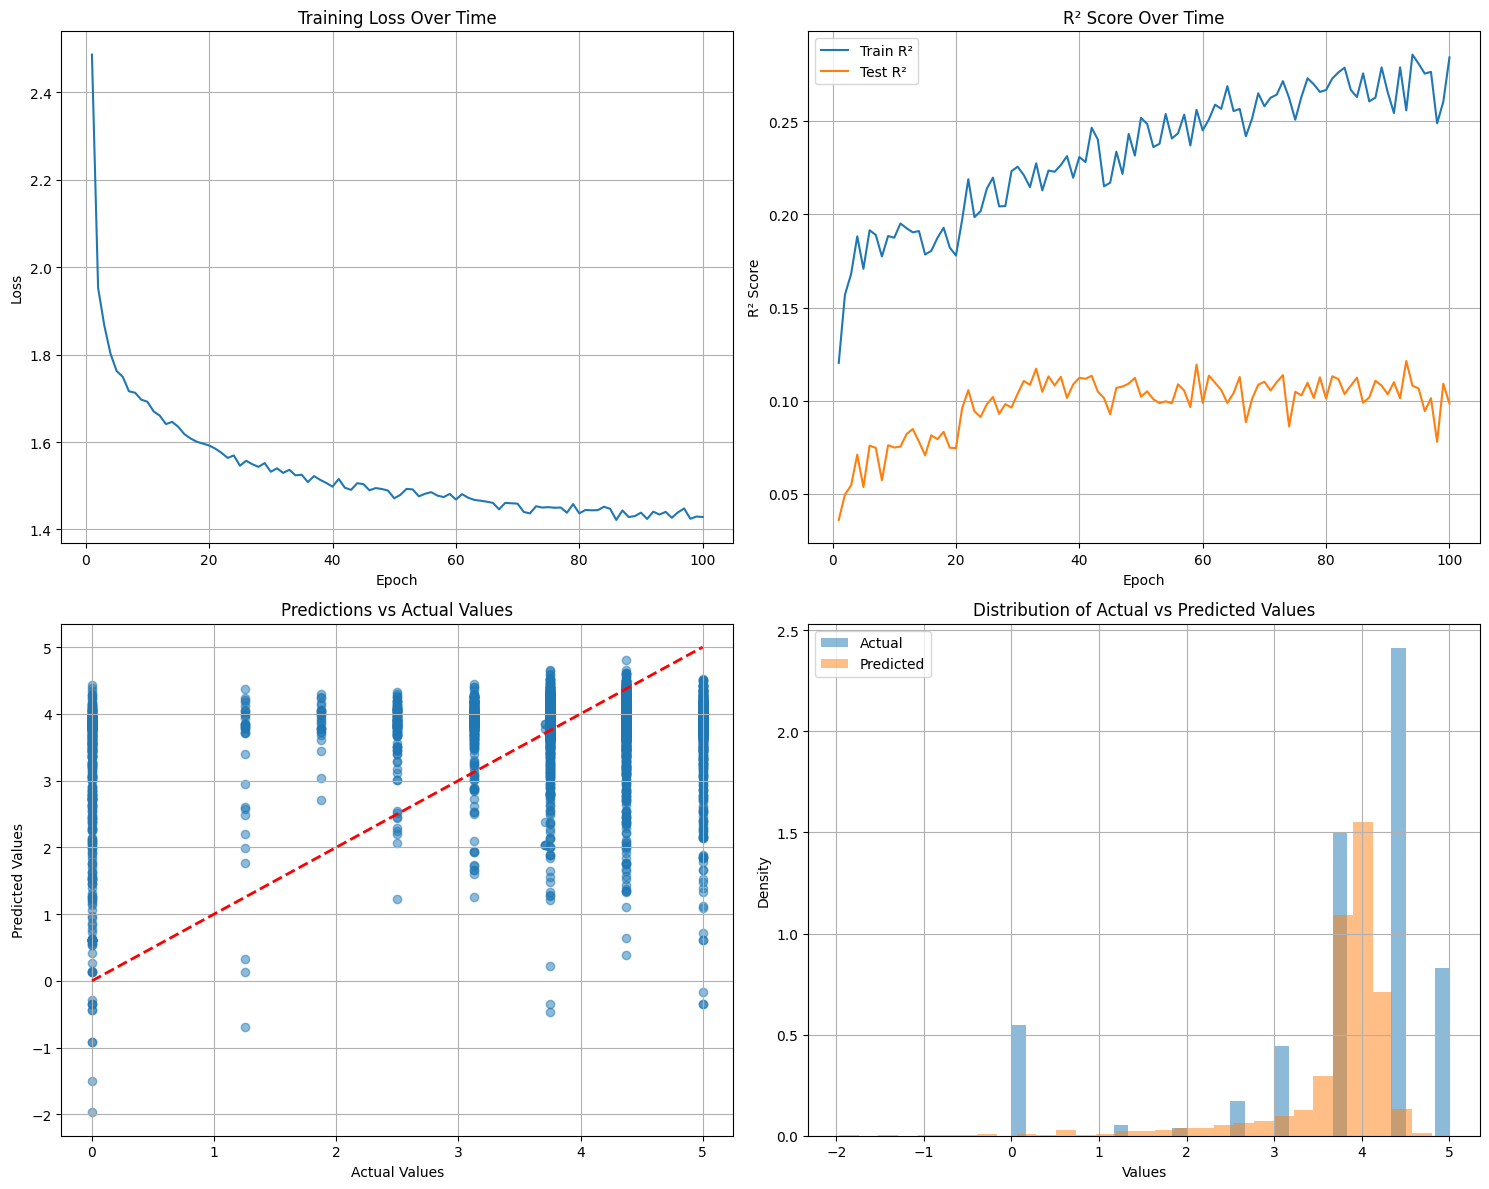

In [466]:
# Visualization code
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training Loss Over Time
ax1.plot(epochs_list, train_losses)
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot 2: R² Score Over Time
ax2.plot(epochs_list, train_r2_scores, label="Train R²")
ax2.plot(epochs_list, test_r2_scores, label="Test R²")
ax2.set_title("R² Score Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("R² Score")
ax2.legend()
ax2.grid(True)

# Plot 3: Predictions vs Actuals (Scatter)
ax3.scatter(y_test_t.numpy(), test_predictions.numpy(), alpha=0.5)
ax3.plot(
    [y_test_t.min(), y_test_t.max()], [y_test_t.min(), y_test_t.max()], "r--", lw=2
)
ax3.set_title("Predictions vs Actual Values")
ax3.set_xlabel("Actual Values")
ax3.set_ylabel("Predicted Values")
ax3.grid(True)

# Plot 4: Distribution Plot
ax4.hist(y_test_t.numpy().flatten(), bins=30, alpha=0.5, label="Actual", density=True)
ax4.hist(
    test_predictions.numpy().flatten(),
    bins=30,
    alpha=0.5,
    label="Predicted",
    density=True,
)
ax4.set_title("Distribution of Actual vs Predicted Values")
ax4.set_xlabel("Values")
ax4.set_ylabel("Density")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()


In [467]:
model_ML = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.ReLU(),
    nn.Dropout(0.2),  # Reduced dropout
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),  # Reduced dropout
    nn.Linear(64, 1),
)


In [468]:
# Modified optimizer parameters
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model_ML.parameters(), lr=0.0005, weight_decay=0.001
)  # Reduced learning rate, added small weight decay

# Modified training parameters
epochs = 100  # Increased epochs
batch_size = 64  # Increased batch size

# Training loop
for epoch in range(epochs):
    model_ML.train()  # Set to training mode
    total_loss = 0
    num_batches = 0

    for i in range(0, len(X_train), batch_size):
        batch_X = X_train_t[i : i + batch_size]
        batch_y = y_train_t[i : i + batch_size]

        outputs = model_ML(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    if (epoch + 1) % 10 == 0:  # Changed to print every 10 epochs
        print(
            f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}, Loss Item: {loss.item():.4f}"
        )


Epoch [10/100], Average Loss: 1.3628, Loss Item: 1.2807
Epoch [20/100], Average Loss: 1.0657, Loss Item: 0.6094
Epoch [30/100], Average Loss: 0.8448, Loss Item: 0.6573
Epoch [40/100], Average Loss: 0.7024, Loss Item: 0.6335
Epoch [50/100], Average Loss: 0.6021, Loss Item: 0.3311
Epoch [60/100], Average Loss: 0.5413, Loss Item: 0.7559
Epoch [70/100], Average Loss: 0.4840, Loss Item: 0.3204
Epoch [80/100], Average Loss: 0.4394, Loss Item: 0.3628
Epoch [90/100], Average Loss: 0.4227, Loss Item: 0.2755
Epoch [100/100], Average Loss: 0.3994, Loss Item: 0.3859


In [469]:
# Evaluation
model_ML.eval()
with torch.no_grad():
    train_predictions = model_ML(X_train_t)
    train_mse = mean_squared_error(y_train_t.numpy(), train_predictions.numpy())
    train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())

    test_predictions = model_ML(X_test_t)
    test_mse = mean_squared_error(y_test_t.numpy(), test_predictions.numpy())
    test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())

print("\nTraining Set Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")



Training Set Metrics:
MSE: 0.2713
R²: 0.8493

Test Set Metrics:
MSE: 1.6501
R²: 0.0856


In [470]:
model_ML = nn.Sequential(
    nn.Linear(input_size, 32),  # Reduced from 128 to 32
    nn.ReLU(),
    nn.Dropout(0.5),  # Increased dropout
    nn.Linear(32, 16),  # Reduced from 64 to 16
    nn.ReLU(),
    nn.Dropout(0.5),  # Increased dropout
    nn.Linear(16, 1),
)


In [471]:
# Stronger regularization in optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model_ML.parameters(), lr=0.001, weight_decay=0.01
)  # Increased weight decay

# Training parameters
epochs = 100  # Back to original
batch_size = 32  # Back to original

# Training loop
for epoch in range(epochs):
    model_ML.train()
    total_loss = 0
    num_batches = 0

    for i in range(0, len(X_train_t), batch_size):
        batch_X = X_train_t[i : i + batch_size]
        batch_y = y_train_t[i : i + batch_size]

        outputs = model_ML(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}, Loss Item: {loss.item():.4f}"
        )


Epoch [5/100], Average Loss: 2.2072, Loss Item: 1.2165
Epoch [10/100], Average Loss: 1.8533, Loss Item: 2.1693
Epoch [15/100], Average Loss: 1.7432, Loss Item: 1.9265
Epoch [20/100], Average Loss: 1.7121, Loss Item: 1.6976
Epoch [25/100], Average Loss: 1.7123, Loss Item: 1.9764
Epoch [30/100], Average Loss: 1.7137, Loss Item: 2.1461
Epoch [35/100], Average Loss: 1.7162, Loss Item: 1.8288
Epoch [40/100], Average Loss: 1.7116, Loss Item: 1.8141
Epoch [45/100], Average Loss: 1.7140, Loss Item: 1.8366
Epoch [50/100], Average Loss: 1.7063, Loss Item: 1.6707
Epoch [55/100], Average Loss: 1.7057, Loss Item: 1.9914
Epoch [60/100], Average Loss: 1.7093, Loss Item: 1.7515
Epoch [65/100], Average Loss: 1.7071, Loss Item: 1.6925
Epoch [70/100], Average Loss: 1.7065, Loss Item: 1.5006
Epoch [75/100], Average Loss: 1.7062, Loss Item: 1.7814
Epoch [80/100], Average Loss: 1.7103, Loss Item: 1.8908
Epoch [85/100], Average Loss: 1.7137, Loss Item: 1.8394
Epoch [90/100], Average Loss: 1.7106, Loss Item: 

In [472]:
# Evaluation
model_ML.eval()
with torch.no_grad():
    train_predictions = model_ML(X_train_t)
    train_mse = mean_squared_error(y_train_t.numpy(), train_predictions.numpy())
    train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())

    test_predictions = model_ML(X_test_t)
    test_mse = mean_squared_error(y_test_t.numpy(), test_predictions.numpy())
    test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())

print("\nTraining Set Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")



Training Set Metrics:
MSE: 1.6387
R²: 0.0898

Test Set Metrics:
MSE: 1.6911
R²: 0.0629


Linear Regression

In [473]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_train_r2 = lr.score(X_train, y_train)
lr_test_r2 = lr.score(X_test, y_test)
print(f"Linear Regression R² - Train: {lr_train_r2:.4f}, Test: {lr_test_r2:.4f}")


Linear Regression R² - Train: 0.2033, Test: 0.0907


In [474]:
# Calculate correlations with target
correlations = pd.DataFrame(features_scaled).corrwith(df["rating_pre"])
print("Top 5 feature correlations with target:")
print(correlations.abs().sort_values(ascending=False).head())


Top 5 feature correlations with target:
510    0.210376
100    0.201631
390    0.195705
346    0.189941
607    0.187995
dtype: float64


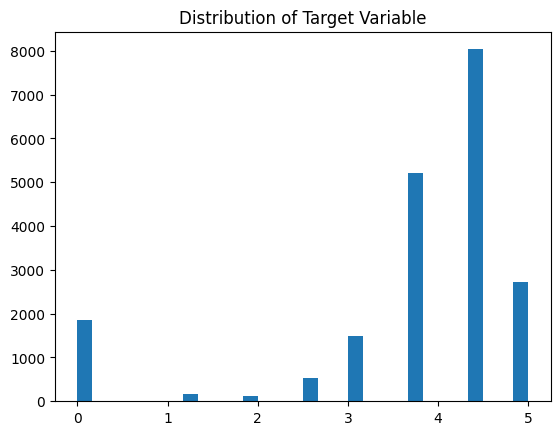

In [475]:
import matplotlib.pyplot as plt

plt.hist(df["rating_pre"], bins=30)
plt.title("Distribution of Target Variable")
plt.show()


# Step 7: Random Forest - BERT

In [476]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(16104, 768) (16104,)
(4026, 768) (4026,)


In [477]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())

0 0


In [478]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
# rf_model.fit(X_train_t.numpy(), y_train_t.numpy().ravel())
rf_model.fit(X_train, y_train)

# Get predictions
rf_train_predictions = rf_model.predict(X_train)
rf_test_predictions = rf_model.predict(X_test)

# Calculate metrics
rf_train_r2 = r2_score(y_train, rf_train_predictions)
rf_test_r2 = r2_score(y_test, rf_test_predictions)
rf_train_mse = mean_squared_error(y_train, rf_train_predictions)
rf_test_mse = mean_squared_error(y_test, rf_test_predictions)

print("\nRandom Forest Metrics:")
print("Training Set:")
print(f"MSE: {rf_train_mse:.4f}")
print(f"R²: {rf_train_r2:.4f}")
print("\nTest Set:")
print(f"MSE: {rf_test_mse:.4f}")
print(f"R²: {rf_test_r2:.4f}")



Random Forest Metrics:
Training Set:
MSE: 0.2921
R²: 0.8378

Test Set:
MSE: 1.6174
R²: 0.1037


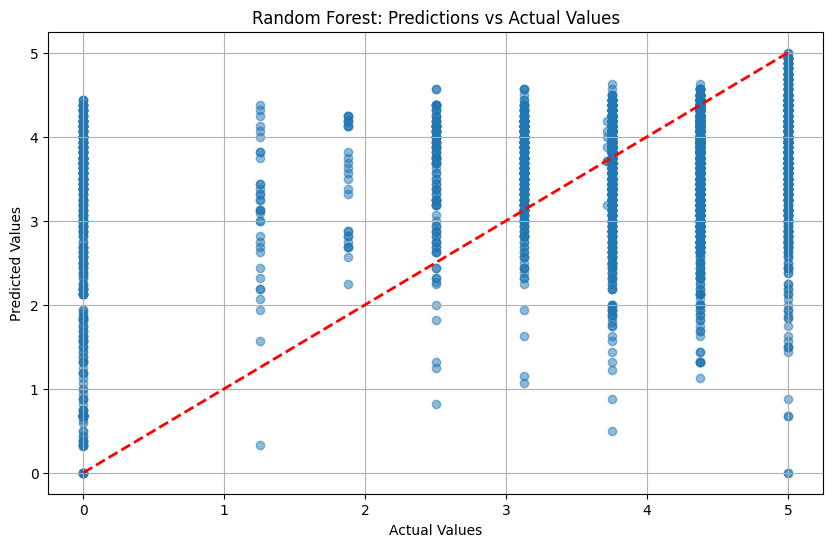

In [479]:
# Single plot for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.title("Random Forest: Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


# Step 3: TF-IDF 

In [480]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)
tfidf_vectors = tfidf.fit_transform(df["directions_post"])
print(f"Created TF-IDF vectors with shape: {tfidf_vectors.shape}")
print(tfidf_vectors)


Created TF-IDF vectors with shape: (20130, 1000)
  (0, 620)	0.11185182617075978
  (0, 857)	0.10197894926865335
  (0, 453)	0.6102839578528649
  (0, 133)	0.09683281848329331
  (0, 126)	0.11724450270041283
  (0, 907)	0.18202482813419094
  (0, 729)	0.03312323435224989
  (0, 500)	0.04869319776978381
  (0, 733)	0.053900185556634304
  (0, 100)	0.05402150285047
  (0, 83)	0.05412306086754615
  (0, 677)	0.06734524551930529
  (0, 388)	0.036022479294293024
  (0, 474)	0.07296690325397776
  (0, 783)	0.055500275507744674
  (0, 890)	0.057207430203032116
  (0, 516)	0.029758646168758635
  (0, 239)	0.13468085698395277
  (0, 67)	0.10849904866259841
  (0, 270)	0.06938125267389296
  (0, 4)	0.03428673807101205
  (0, 962)	0.04702531035515014
  (0, 539)	0.10659565038707988
  (0, 687)	0.05342082773420476
  (0, 246)	0.0756632551378832
  :	:
  (20129, 558)	0.15366321950049242
  (20129, 638)	0.032147086654263274
  (20129, 48)	0.029147171314353893
  (20129, 79)	0.03532979268043154
  (20129, 761)	0.03420600590443411

# Step 6.2: Neural network TF-IDF

In [483]:
features_scaled = StandardScaler().fit_transform(tfidf_vectors.toarray())
targets = df["rating_pre"]
print("Scaled features shape:", features_scaled.shape)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, targets, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
X_test_t = torch.FloatTensor(X_test)
y_train_t = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_t = torch.FloatTensor(y_test.values).reshape(-1, 1)
print("X_train tensor shape:", X_train_t.shape)
print("y_train tensor shape:", y_train_t.shape)

# Now create the model with the correct input size
input_size = X_train.shape[1]  # This will get the correct dimension
print("Input size:", input_size)


Scaled features shape: (20130, 1000)
X_train shape: (16104, 1000)
y_train shape: (16104,)
X_train tensor shape: torch.Size([16104, 1000])
y_train tensor shape: torch.Size([16104, 1])
Input size: 1000


In [ ]:
model_ML = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.ReLU(),
    nn.Dropout(0.3),  # Add dropout
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),  # Add dropout
    nn.Linear(64, 1),
)


In [485]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model_ML.parameters(), lr=0.001, weight_decay=0.01
)  # Add weight_decay

# Lists to store metrics
train_losses = []
epochs_list = []
train_r2_scores = []
test_r2_scores = []  # Added test R² tracking

# Training loop
epochs = 100
batch_size = 32

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    for i in range(0, len(X_train_t), batch_size):
        batch_X = X_train_t[i : i + batch_size]
        batch_y = y_train_t[i : i + batch_size]

        outputs = model_ML(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # Calculate average loss for this epoch
    avg_loss = total_loss / num_batches

    # Calculate R² scores for both train and test
    model_ML.eval()
    with torch.no_grad():
        train_predictions = model_ML(X_train_t)
        test_predictions = model_ML(X_test_t)
        train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())
        test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())
    model_ML.train()

    # Store metrics
    train_losses.append(avg_loss)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)  # Store test R²
    epochs_list.append(epoch + 1)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}"
        )


Epoch [5/100], Loss: 1.4084, Train R²: 0.4183, Test R²: 0.0801
Epoch [10/100], Loss: 1.1364, Train R²: 0.5238, Test R²: 0.0665
Epoch [15/100], Loss: 0.9916, Train R²: 0.6224, Test R²: 0.1123
Epoch [20/100], Loss: 0.9349, Train R²: 0.5912, Test R²: 0.1195
Epoch [25/100], Loss: 0.8757, Train R²: 0.6416, Test R²: 0.0963
Epoch [30/100], Loss: 0.8325, Train R²: 0.6484, Test R²: 0.1163
Epoch [35/100], Loss: 0.8233, Train R²: 0.6641, Test R²: 0.0951
Epoch [40/100], Loss: 0.8040, Train R²: 0.6695, Test R²: 0.1425
Epoch [45/100], Loss: 0.7943, Train R²: 0.6676, Test R²: 0.1431
Epoch [50/100], Loss: 0.7603, Train R²: 0.6716, Test R²: 0.1254
Epoch [55/100], Loss: 0.7775, Train R²: 0.6875, Test R²: 0.1255
Epoch [60/100], Loss: 0.7660, Train R²: 0.6763, Test R²: 0.1276
Epoch [65/100], Loss: 0.7600, Train R²: 0.6646, Test R²: 0.1112
Epoch [70/100], Loss: 0.7641, Train R²: 0.6894, Test R²: 0.1071
Epoch [75/100], Loss: 0.7605, Train R²: 0.6749, Test R²: 0.1303
Epoch [80/100], Loss: 0.7442, Train R²: 0

In [486]:
# Final evaluation
model_ML.eval()
with torch.no_grad():
    # Get predictions for training set
    train_predictions = model_ML(X_train_t)
    train_mse = mean_squared_error(y_train_t.numpy(), train_predictions.numpy())
    train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())

    # Get predictions for test set
    test_predictions = model_ML(X_test_t)
    test_mse = mean_squared_error(y_test_t.numpy(), test_predictions.numpy())
    test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())

print("\nTraining Set Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")



Training Set Metrics:
MSE: 0.5637
R²: 0.6869

Test Set Metrics:
MSE: 1.5616
R²: 0.1346


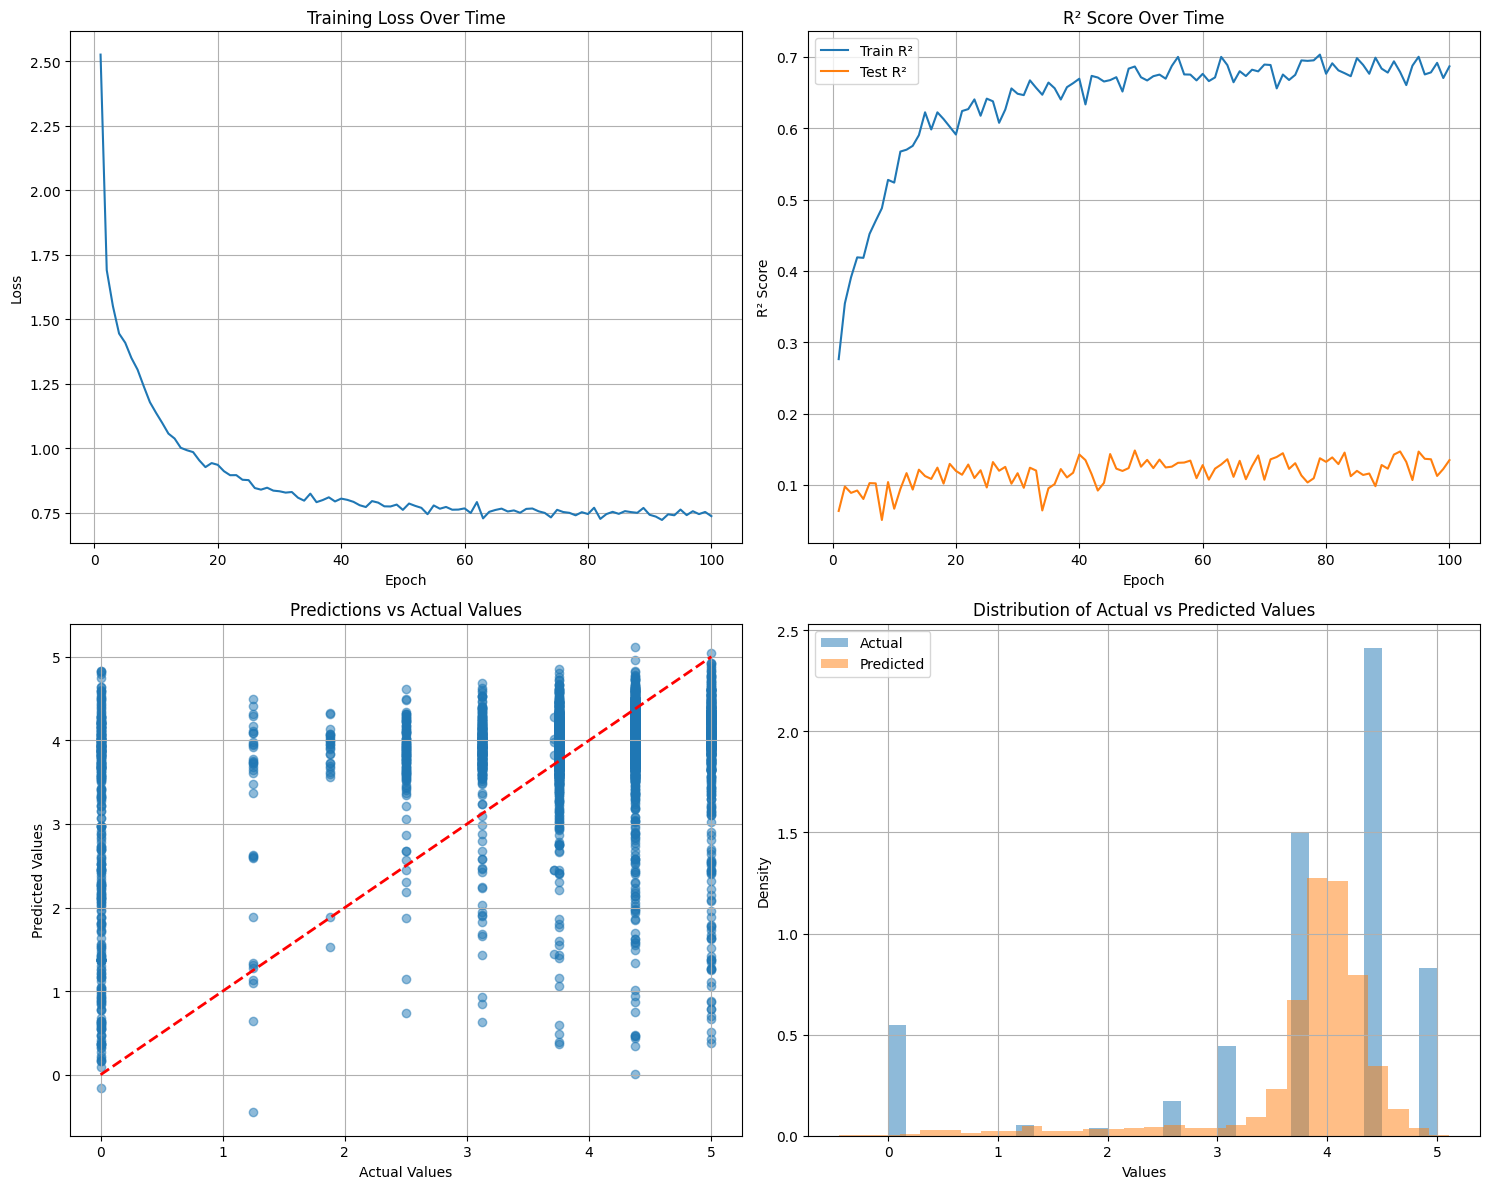

In [ ]:
# Visualization code
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training Loss Over Time
ax1.plot(epochs_list, train_losses)
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot 2: R² Score Over Time
ax2.plot(epochs_list, train_r2_scores, label="Train R²")
ax2.plot(epochs_list, test_r2_scores, label="Test R²")
ax2.set_title("R² Score Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("R² Score")
ax2.legend()
ax2.grid(True)

# Plot 3: Predictions vs Actuals (Scatter)
ax3.scatter(y_test_t.numpy(), test_predictions.numpy(), alpha=0.5)
ax3.plot(
    [y_test_t.min(), y_test_t.max()], [y_test_t.min(), y_test_t.max()], "r--", lw=2
)
ax3.set_title("Predictions vs Actual Values")
ax3.set_xlabel("Actual Values")
ax3.set_ylabel("Predicted Values")
ax3.grid(True)

# Plot 4: Distribution Plot
ax4.hist(y_test_t.numpy().flatten(), bins=30, alpha=0.5, label="Actual", density=True)
ax4.hist(
    test_predictions.numpy().flatten(),
    bins=30,
    alpha=0.5,
    label="Predicted",
    density=True,
)
ax4.set_title("Distribution of Actual vs Predicted Values")
ax4.set_xlabel("Values")
ax4.set_ylabel("Density")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()


# Step 7.2: Random Forest - TF-IDF

In [488]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
# rf_model.fit(X_train_t.numpy(), y_train_t.numpy().ravel())
rf_model.fit(X_train, y_train)

# Get predictions
rf_train_predictions = rf_model.predict(X_train)
rf_test_predictions = rf_model.predict(X_test)

# Calculate metrics
rf_train_r2 = r2_score(y_train, rf_train_predictions)
rf_test_r2 = r2_score(y_test, rf_test_predictions)
rf_train_mse = mean_squared_error(y_train, rf_train_predictions)
rf_test_mse = mean_squared_error(y_test, rf_test_predictions)

print("\nRandom Forest Metrics:")
print("Training Set:")
print(f"MSE: {rf_train_mse:.4f}")
print(f"R²: {rf_train_r2:.4f}")
print("\nTest Set:")
print(f"MSE: {rf_test_mse:.4f}")
print(f"R²: {rf_test_r2:.4f}")



Random Forest Metrics:
Training Set:
MSE: 0.2720
R²: 0.8489

Test Set:
MSE: 1.5540
R²: 0.1388


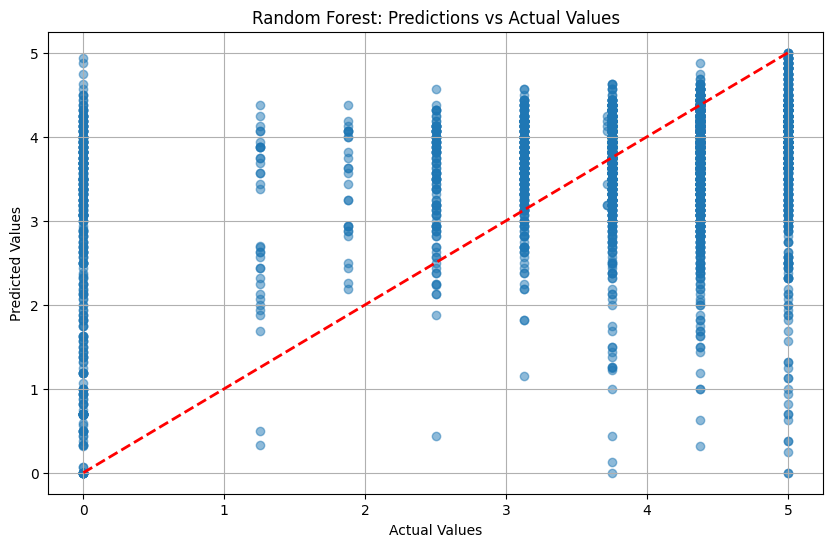

In [489]:
# Single plot for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.title("Random Forest: Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


# Step 4: Word2Vec

In [ ]:
from gensim.models import Word2Vec

sentences = [text.split() for text in df["directions_post"]]
vector_size = 100

w2v_model = Word2Vec(
    sentences, vector_size=vector_size, window=5, min_count=1, workers=4
)

# Create document vectors by averaging word vectors
doc_vectors = []
for sentence in sentences:
    word_vectors = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
    if word_vectors:
        doc_vectors.append(np.mean(word_vectors, axis=0))
    else:
        doc_vectors.append(np.zeros(vector_size))

W2V_vectors = np.array(doc_vectors)
print(f"Created Word2Vec vectors with shape: {W2V_vectors.shape}")
print(W2V_vectors)


Created Word2Vec vectors with shape: (20130, 100)
[[ 0.06257126  0.14635481 -0.00529966 ...  0.09233781 -0.08889184
   0.41230115]
 [ 0.1206885   0.04569312 -0.37331665 ...  0.16647248 -0.2277115
   0.44750088]
 [ 0.47547784 -0.39492604 -0.24628368 ...  0.67549866 -0.42873144
   0.50908417]
 ...
 [ 0.51039267  0.31893486  0.15106615 ...  0.35694391 -0.30840802
   0.51504159]
 [ 0.43578121  0.08325904 -0.12926374 ...  0.34422207  0.04518572
   0.17524524]
 [ 0.22939694  0.30637816 -0.11453412 ...  0.40345341  0.37767285
   0.72649097]]


# Step 6.3: Neural network Word2Vec

In [491]:
features_scaled = StandardScaler().fit_transform(W2V_vectors)
targets = df["rating_pre"]
print("Scaled features shape:", features_scaled.shape)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, targets, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
X_test_t = torch.FloatTensor(X_test)
y_train_t = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_t = torch.FloatTensor(y_test.values).reshape(-1, 1)
print("X_train tensor shape:", X_train_t.shape)
print("y_train tensor shape:", y_train_t.shape)

# Now create the model with the correct input size
input_size = X_train.shape[1]  # This will get the correct dimension
print("Input size:", input_size)


Scaled features shape: (20130, 100)
X_train shape: (16104, 100)
y_train shape: (16104,)
X_train tensor shape: torch.Size([16104, 100])
y_train tensor shape: torch.Size([16104, 1])
Input size: 100


In [ ]:
model_ML = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.ReLU(),
    nn.Dropout(0.3),  # Add dropout
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),  # Add dropout
    nn.Linear(64, 1),
)


In [493]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model_ML.parameters(), lr=0.001, weight_decay=0.01
)  # Add weight_decay

# Lists to store metrics
train_losses = []
epochs_list = []
train_r2_scores = []
test_r2_scores = []  # Added test R² tracking

# Training loop
epochs = 100
batch_size = 32

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    for i in range(0, len(X_train_t), batch_size):
        batch_X = X_train_t[i : i + batch_size]
        batch_y = y_train_t[i : i + batch_size]

        outputs = model_ML(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # Calculate average loss for this epoch
    avg_loss = total_loss / num_batches

    # Calculate R² scores for both train and test
    model_ML.eval()
    with torch.no_grad():
        train_predictions = model_ML(X_train_t)
        test_predictions = model_ML(X_test_t)
        train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())
        test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())
    model_ML.train()

    # Store metrics
    train_losses.append(avg_loss)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)  # Store test R²
    epochs_list.append(epoch + 1)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}"
        )


Epoch [5/100], Loss: 1.7824, Train R²: 0.1292, Test R²: 0.0963
Epoch [10/100], Loss: 1.6731, Train R²: 0.1475, Test R²: 0.1162
Epoch [15/100], Loss: 1.6402, Train R²: 0.1525, Test R²: 0.1186
Epoch [20/100], Loss: 1.5991, Train R²: 0.1617, Test R²: 0.1207
Epoch [25/100], Loss: 1.5787, Train R²: 0.1733, Test R²: 0.1254
Epoch [30/100], Loss: 1.5549, Train R²: 0.1750, Test R²: 0.1201
Epoch [35/100], Loss: 1.5505, Train R²: 0.1802, Test R²: 0.1269
Epoch [40/100], Loss: 1.5459, Train R²: 0.1813, Test R²: 0.1256
Epoch [45/100], Loss: 1.5224, Train R²: 0.1896, Test R²: 0.1301
Epoch [50/100], Loss: 1.5272, Train R²: 0.1845, Test R²: 0.1245
Epoch [55/100], Loss: 1.5189, Train R²: 0.1814, Test R²: 0.1236
Epoch [60/100], Loss: 1.5195, Train R²: 0.1918, Test R²: 0.1285
Epoch [65/100], Loss: 1.5235, Train R²: 0.1917, Test R²: 0.1265
Epoch [70/100], Loss: 1.5177, Train R²: 0.1913, Test R²: 0.1264
Epoch [75/100], Loss: 1.5155, Train R²: 0.1940, Test R²: 0.1276
Epoch [80/100], Loss: 1.5082, Train R²: 0

In [494]:
# Final evaluation
model_ML.eval()
with torch.no_grad():
    # Get predictions for training set
    train_predictions = model_ML(X_train_t)
    train_mse = mean_squared_error(y_train_t.numpy(), train_predictions.numpy())
    train_r2 = r2_score(y_train_t.numpy(), train_predictions.numpy())

    # Get predictions for test set
    test_predictions = model_ML(X_test_t)
    test_mse = mean_squared_error(y_test_t.numpy(), test_predictions.numpy())
    test_r2 = r2_score(y_test_t.numpy(), test_predictions.numpy())

print("\nTraining Set Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"R²: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")



Training Set Metrics:
MSE: 1.4295
R²: 0.2060

Test Set Metrics:
MSE: 1.5629
R²: 0.1339


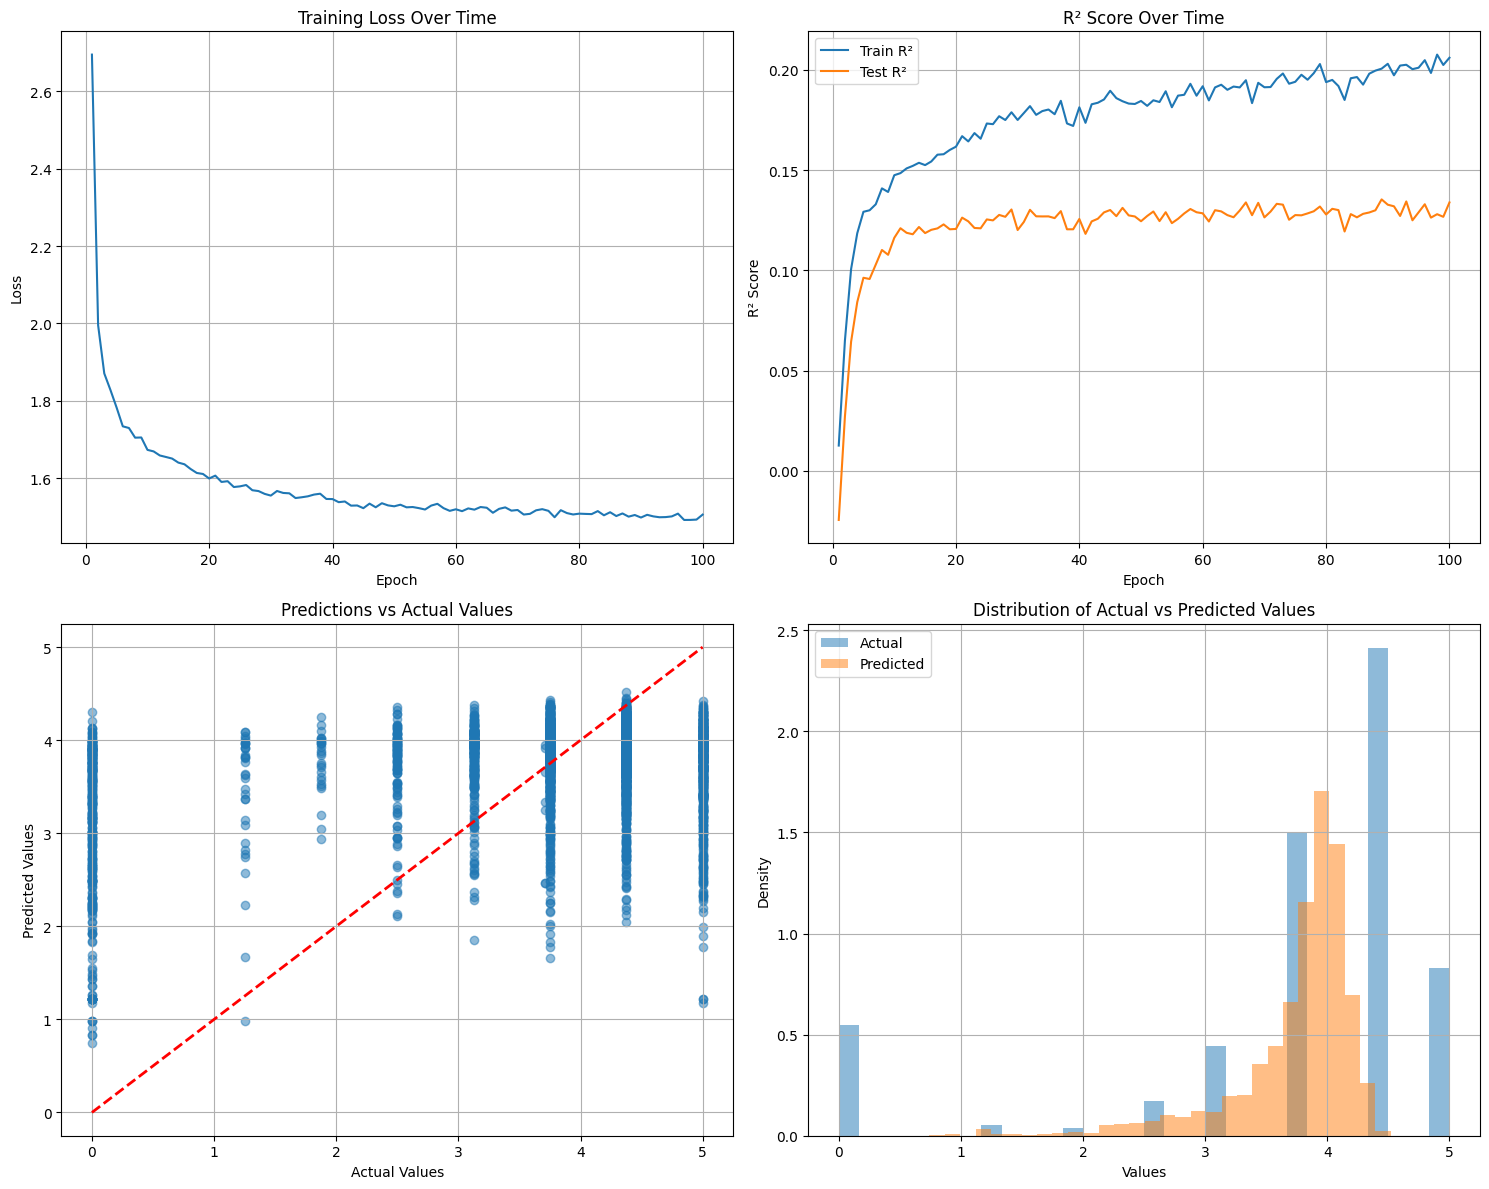

In [495]:
# Visualization code
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training Loss Over Time
ax1.plot(epochs_list, train_losses)
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot 2: R² Score Over Time
ax2.plot(epochs_list, train_r2_scores, label="Train R²")
ax2.plot(epochs_list, test_r2_scores, label="Test R²")
ax2.set_title("R² Score Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("R² Score")
ax2.legend()
ax2.grid(True)

# Plot 3: Predictions vs Actuals (Scatter)
ax3.scatter(y_test_t.numpy(), test_predictions.numpy(), alpha=0.5)
ax3.plot(
    [y_test_t.min(), y_test_t.max()], [y_test_t.min(), y_test_t.max()], "r--", lw=2
)
ax3.set_title("Predictions vs Actual Values")
ax3.set_xlabel("Actual Values")
ax3.set_ylabel("Predicted Values")
ax3.grid(True)

# Plot 4: Distribution Plot
ax4.hist(y_test_t.numpy().flatten(), bins=30, alpha=0.5, label="Actual", density=True)
ax4.hist(
    test_predictions.numpy().flatten(),
    bins=30,
    alpha=0.5,
    label="Predicted",
    density=True,
)
ax4.set_title("Distribution of Actual vs Predicted Values")
ax4.set_xlabel("Values")
ax4.set_ylabel("Density")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()


# Step 7.2: Random Forest - Word2Vec

In [496]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
# rf_model.fit(X_train_t.numpy(), y_train_t.numpy().ravel())
rf_model.fit(X_train, y_train)

# Get predictions
rf_train_predictions = rf_model.predict(X_train)
rf_test_predictions = rf_model.predict(X_test)

# Calculate metrics
rf_train_r2 = r2_score(y_train, rf_train_predictions)
rf_test_r2 = r2_score(y_test, rf_test_predictions)
rf_train_mse = mean_squared_error(y_train, rf_train_predictions)
rf_test_mse = mean_squared_error(y_test, rf_test_predictions)

print("\nRandom Forest Metrics:")
print("Training Set:")
print(f"MSE: {rf_train_mse:.4f}")
print(f"R²: {rf_train_r2:.4f}")
print("\nTest Set:")
print(f"MSE: {rf_test_mse:.4f}")
print(f"R²: {rf_test_r2:.4f}")



Random Forest Metrics:
Training Set:
MSE: 0.2798
R²: 0.8446

Test Set:
MSE: 1.5485
R²: 0.1419


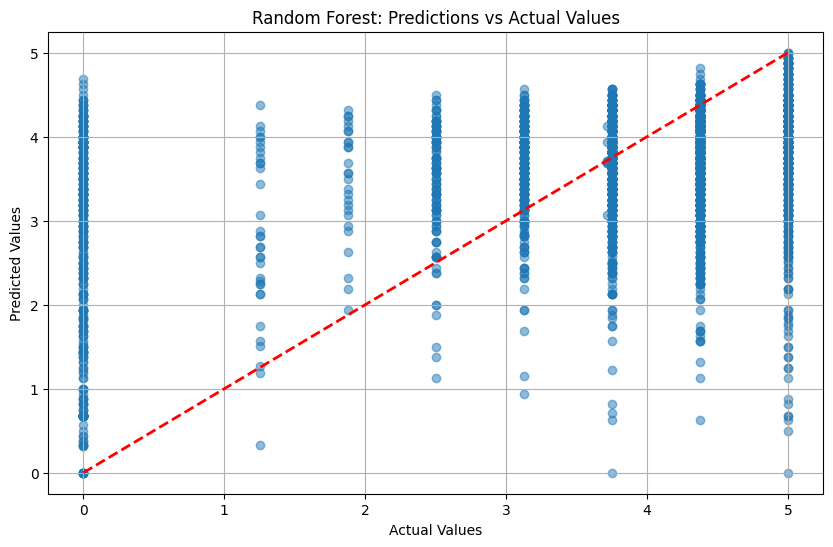

In [497]:
# Single plot for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.title("Random Forest: Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


# Step 8: Hugging Face

In [517]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "distilbert-base-uncased"
batch_size = 32

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
model = model.to(device)

robert_vectors = []  # Initialize predictions list

# Process in batches
for i in range(0, len(df), batch_size):
    batch_texts = df["directions_post"].iloc[i : i + batch_size].tolist()
    inputs = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        # Get regression predictions
        batch_predictions = outputs.logits.squeeze().cpu().numpy()
        robert_vectors.extend(batch_predictions)

# Convert to numpy array if needed
robert_vectors = np.array(robert_vectors)
print(f"Created BERT vectors with shape: {robert_vectors.shape}")


d:\01_MASTER\1 COURSE\1 semester\DATA PROCESSING\final-project-data-processing-JL-IA\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Iker_Al\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DistilBertForSequenceClassification w

Created BERT vectors with shape: (20130,)


In [518]:
print(f"Created ROBERT vectors with shape: {robert_vectors.shape}")
features_scaled = StandardScaler().fit_transform(robert_vectors.reshape(-1, 1))

targets = df["rating_pre"]
print("Scaled features shape:", features_scaled.shape)

# Normalize targets too
target_scaler = StandardScaler()
targets_scaled = target_scaler.fit_transform(targets.values.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, targets_scaled, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
X_test_t = torch.FloatTensor(X_test)
y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
y_test_t = torch.FloatTensor(y_test).reshape(-1, 1)
print("X_train tensor shape:", X_train_t.shape)
print("y_train tensor shape:", y_train_t.shape)

# Now create the model with the correct input size
input_size = X_train.shape[1]  # This will get the correct dimension
print("Input size:", input_size)


Created ROBERT vectors with shape: (20130,)
Scaled features shape: (20130, 1)
X_train shape: (16104, 1)
y_train shape: (16104, 1)
X_train tensor shape: torch.Size([16104, 1])
y_train tensor shape: torch.Size([16104, 1])
Input size: 1


In [ ]:
model_ML = nn.Sequential(
    nn.Linear(input_size, 128),  # Larger first layer
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.1),  # Reduced dropout
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.1),
    nn.Linear(64, 1),
)


In [ ]:
# Modified optimizer settings
criterion = nn.MSELoss()
optimizer = optim.Adam(model_ML.parameters(), lr=0.0005)  # Lower learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.2,  # More aggressive LR reduction
    patience=5,  # Reduced patience
    verbose=True,
)

# Training loop
epochs = 100
batch_size = 32  # Increased batch size

for epoch in range(epochs):
    model_ML.train()
    total_loss = 0
    num_batches = 0

    for i in range(0, len(X_train_t), batch_size):
        batch_X = X_train_t[i : i + batch_size]
        batch_y = y_train_t[i : i + batch_size]

        outputs = model_ML(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    scheduler.step(avg_loss)  # Update learning rate

    # Evaluation
    model_ML.eval()
    with torch.no_grad():
        train_predictions = model_ML(X_train_t)
        test_predictions = model_ML(X_test_t)

        # Convert back to original scale for R² calculation
        train_pred_orig = target_scaler.inverse_transform(train_predictions.numpy())
        test_pred_orig = target_scaler.inverse_transform(test_predictions.numpy())
        y_train_orig = target_scaler.inverse_transform(y_train_t.numpy())
        y_test_orig = target_scaler.inverse_transform(y_test_t.numpy())

        train_r2 = r2_score(y_train_orig, train_pred_orig)
        test_r2 = r2_score(y_test_orig, test_pred_orig)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}"
        )


d:\01_MASTER\1 COURSE\1 semester\DATA PROCESSING\final-project-data-processing-JL-IA\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [5/100], Loss: 0.9592, Train R²: -0.0422, Test R²: -0.0979
Epoch [10/100], Loss: 0.9596, Train R²: -0.0420, Test R²: -0.1185
Epoch [15/100], Loss: 0.9555, Train R²: -0.0315, Test R²: -0.0950
Epoch [20/100], Loss: 0.9512, Train R²: 0.0027, Test R²: -0.0202
Epoch [25/100], Loss: 0.9531, Train R²: -0.1029, Test R²: -0.2545
Epoch [30/100], Loss: 0.9468, Train R²: -0.0248, Test R²: -0.0828
Epoch [35/100], Loss: 0.9458, Train R²: -0.0056, Test R²: -0.0428
Epoch [40/100], Loss: 0.9441, Train R²: 0.0052, Test R²: -0.0072
Epoch [45/100], Loss: 0.9461, Train R²: -0.0044, Test R²: -0.0237
Epoch [50/100], Loss: 0.9441, Train R²: -0.0047, Test R²: -0.0250
Epoch [55/100], Loss: 0.9458, Train R²: -0.0105, Test R²: -0.0311
Epoch [60/100], Loss: 0.9459, Train R²: -0.0123, Test R²: -0.0376
Epoch [65/100], Loss: 0.9440, Train R²: -0.0169, Test R²: -0.0434
Epoch [70/100], Loss: 0.9447, Train R²: -0.0099, Test R²: -0.0347
Epoch [75/100], Loss: 0.9437, Train R²: -0.0139, Test R²: -0.0403
Epoch [80/100

In [ ]:
# Final evaluation
model_ML.eval()
with torch.no_grad():
    train_predictions = model_ML(X_train_t)
    test_predictions = model_ML(X_test_t)

    # Convert predictions back to original scale
    train_pred_orig = target_scaler.inverse_transform(train_predictions.numpy())
    test_pred_orig = target_scaler.inverse_transform(test_predictions.numpy())
    y_train_orig = target_scaler.inverse_transform(y_train_t.numpy())
    y_test_orig = target_scaler.inverse_transform(y_test_t.numpy())

    train_mse_HF = mean_squared_error(y_train_orig, train_pred_orig)
    train_r2_HF = r2_score(y_train_orig, train_pred_orig)
    test_mse_HF = mean_squared_error(y_test_orig, test_pred_orig)
    test_r2_HF = r2_score(y_test_orig, test_pred_orig)

print("\nTraining Set Metrics:")
print(f"MSE: {train_mse_HF:.4f}")
print(f"R²: {train_r2_HF:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"R²: {test_r2:.4f}")



Training Set Metrics:
MSE: 1.8220
R²: -0.0120

Test Set Metrics:
MSE: 1.8745
R²: -0.0388


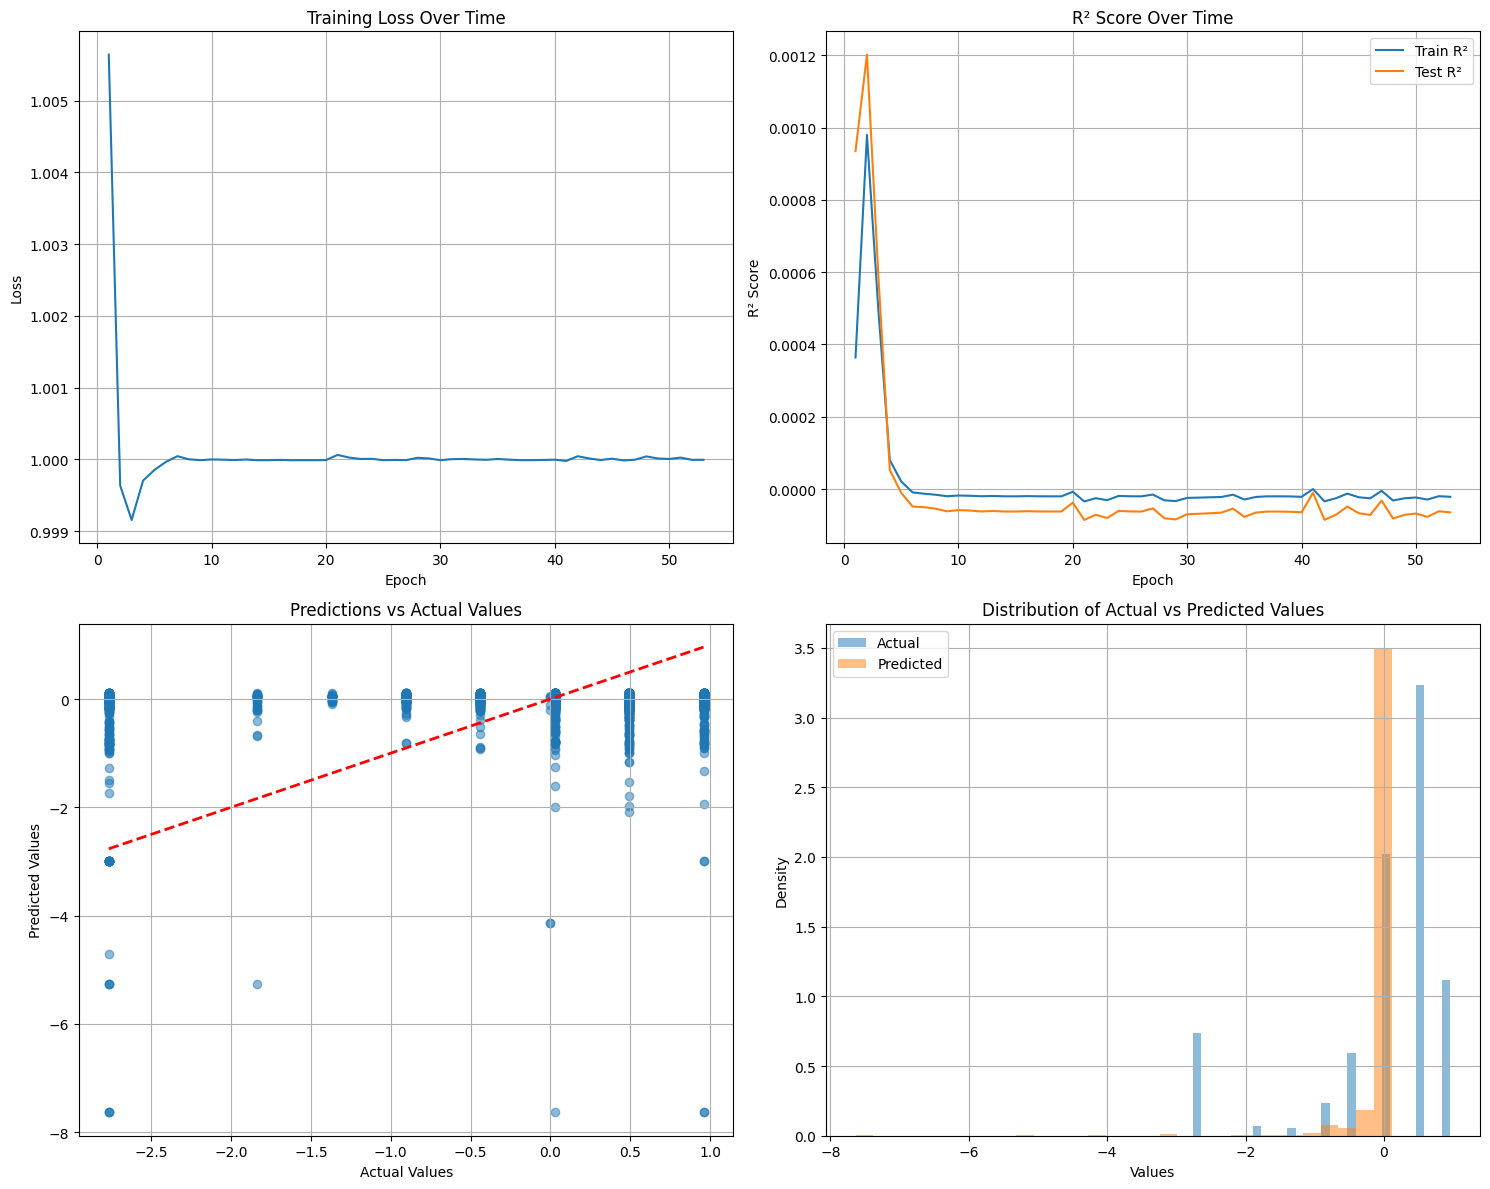

In [526]:
# Visualization code
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training Loss Over Time
ax1.plot(epochs_list, train_losses)
ax1.set_title("Training Loss Over Time")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot 2: R² Score Over Time
ax2.plot(epochs_list, train_r2_scores, label="Train R²")
ax2.plot(epochs_list, test_r2_scores, label="Test R²")
ax2.set_title("R² Score Over Time")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("R² Score")
ax2.legend()
ax2.grid(True)

# Plot 3: Predictions vs Actuals (Scatter)
ax3.scatter(y_test_t.numpy(), test_predictions.numpy(), alpha=0.5)
ax3.plot(
    [y_test_t.min(), y_test_t.max()], [y_test_t.min(), y_test_t.max()], "r--", lw=2
)
ax3.set_title("Predictions vs Actual Values")
ax3.set_xlabel("Actual Values")
ax3.set_ylabel("Predicted Values")
ax3.grid(True)

# Plot 4: Distribution Plot
ax4.hist(y_test_t.numpy().flatten(), bins=30, alpha=0.5, label="Actual", density=True)
ax4.hist(
    test_predictions.numpy().flatten(),
    bins=30,
    alpha=0.5,
    label="Predicted",
    density=True,
)
ax4.set_title("Distribution of Actual vs Predicted Values")
ax4.set_xlabel("Values")
ax4.set_ylabel("Density")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()


# Step 9: Model Comparison

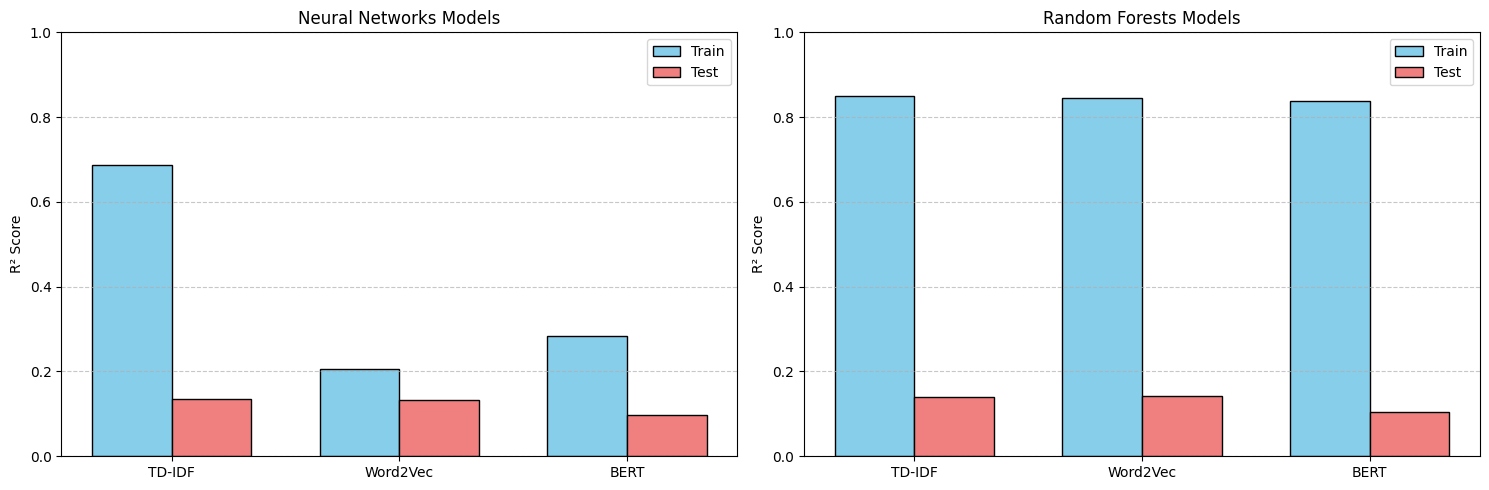

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Model data
models_nn = ["TD-IDF", "Word2Vec", "BERT"]
r2_result_train_nn = [0.6869, 0.206, 0.2843]
r2_result_test_nn = [0.1346, 0.1339, 0.0985]

models_rf = ["TD-IDF", "Word2Vec", "BERT"]
r2_result_train_rf = [0.8489, 0.844, 0.8378]
r2_result_test_rf = [0.1388, 0.1419, 0.1037]

# Plot Neural Networks
x = np.arange(len(models_nn))
width = 0.35

ax1.bar(
    x - width / 2,
    r2_result_train_nn,
    width,
    label="Train",
    color="skyblue",
    edgecolor="black",
)
ax1.bar(
    x + width / 2,
    r2_result_test_nn,
    width,
    label="Test",
    color="lightcoral",
    edgecolor="black",
)
ax1.set_ylabel("R² Score")
ax1.set_title("Neural Networks Models")
ax1.set_xticks(x)
ax1.set_xticklabels(models_nn)
ax1.legend()
ax1.grid(axis="y", linestyle="--", alpha=0.7)
ax1.set_ylim(0, 1)

# Plot Random Forests
ax2.bar(
    x - width / 2,
    r2_result_train_rf,
    width,
    label="Train",
    color="skyblue",
    edgecolor="black",
)
ax2.bar(
    x + width / 2,
    r2_result_test_rf,
    width,
    label="Test",
    color="lightcoral",
    edgecolor="black",
)
ax2.set_ylabel("R² Score")
ax2.set_title("Random Forests Models")
ax2.set_xticks(x)
ax2.set_xticklabels(models_rf)
ax2.legend()
ax2.grid(axis="y", linestyle="--", alpha=0.7)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()
